## Initialise Notebook

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("talk")

c:\Github\ode-biomarker-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [4]:
# attempt load from loading code

loading_code = 'fgfr4_model_raw_simulation'
simulation_data = data_link.get_data_from_code(loading_code)

In [5]:
loading_code = 'fgfr4_ccle_dynamic_features_v2'
dynamic_features = data_link.get_data_from_code(loading_code)

## Analysis Chain

In [6]:
### OPTIONS

target_protein = "pAkt"
folder_name = "FGFR4_Single_Cluster_Analysis"
exp_id = "v2-pAkt"
fixed_random_seed = 42 # -1 for no seed
umap_params = {
    # ADD YOUR OWN HERE
    'random_state': fixed_random_seed
}

hbd_params = {
    # ADD YOUR OWN HERE
    'min_cluster_size': 50,
    'min_samples': 10,
}


# plot options
dynamic_plot_cols = 2
ncluster_plot_cols = 2
normalise_simulation_dynamics = False
save_figure = True
display_figure = True
projection_show_legend = True

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


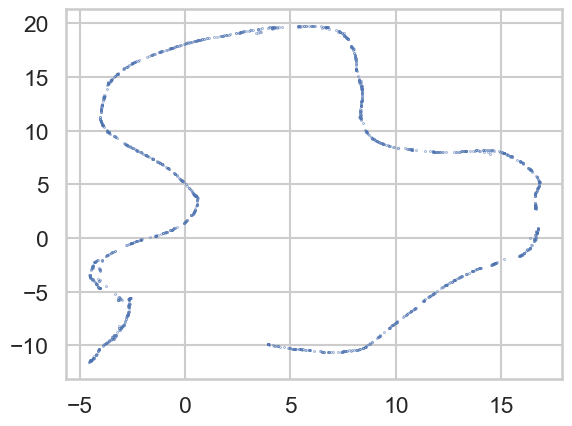

In [7]:
indexed_dyn_feats = dynamic_features.set_index('Row')
target_dynamic_features = indexed_dyn_feats.filter(like=target_protein, axis=1)

dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']
joint_dyn_feat_data = []
for row in range(target_dynamic_features.shape[0]):
    ptp_data = target_dynamic_features.iloc[row].tolist()
    joint_dyn_feat_data.append(ptp_data)
    
joint_dynamic_features = pd.DataFrame(joint_dyn_feat_data, columns=dyn_feat_cols)

standard_embedding = umap.UMAP(**umap_params).fit_transform(joint_dynamic_features)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)

In [8]:
hbd_labels = hdbscan.HDBSCAN(**hbd_params).fit_predict(joint_dynamic_features)

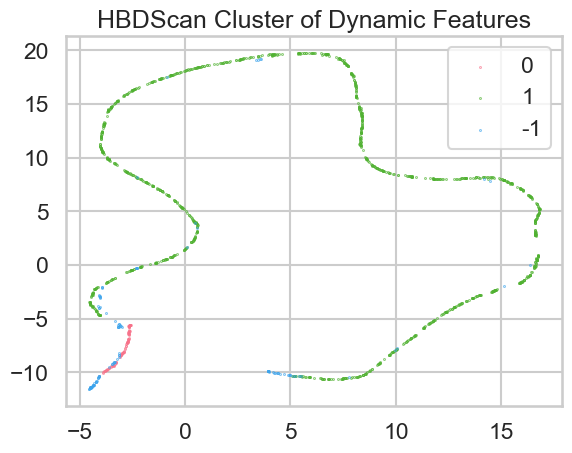

In [9]:
n_clusters = set(hbd_labels)
plot_colors_cluster = sns.color_palette("husl", len(list(n_clusters)))

for k, cluster in enumerate(list(n_clusters)):
    plot_data_x = []
    plot_data_y = []
    for i, label in enumerate(hbd_labels):
        if label == cluster:
            x = standard_embedding[i][0]
            y = standard_embedding[i][1]
            plot_data_x.append(x)
            plot_data_y.append(y)

    plt.scatter(plot_data_x, plot_data_y, color=plot_colors_cluster[k], s=0.2, label=cluster, alpha=0.9) 
    
if projection_show_legend: plt.legend()
plt.title('HBDScan Cluster of Dynamic Features')
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_hbdscan_cluster_{fixed_random_seed}.png')
plt.show()

In [10]:
all_celllines = simulation_data['Cellline'].unique()
all_proteins = simulation_data.columns[2:]

protein_df_data = []

count = 0
for cellline in all_celllines:
    for protein in all_proteins:
        if protein == 'pAkt':
            cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
            protein_data = cellline_protein_data[protein]
            protein_df_data.append(protein_data.tolist())

time_column_df = pd.DataFrame(protein_df_data, columns=cellline_protein_data['Time'])

<AxesSubplot: xlabel='Time'>

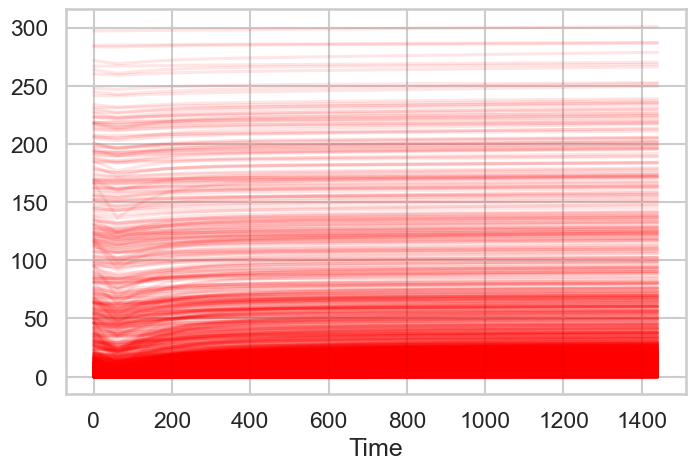

In [11]:
# plot time column df 

time_column_df = time_column_df.T
time_column_df.plot(legend=False, alpha=0.1, color='red', figsize=(8, 5))

Variance Visualisation for Dynamic Features

In [12]:
mean_df = joint_dynamic_features.mean()

In [13]:
mean_df

auc       0.032610
median    0.036789
tfc       8.290536
tmax      0.999316
max       0.053625
tmin      0.040000
min       0.007289
ttsv      0.058775
tsv       0.012989
init      0.007289
dtype: float64

In [14]:
std_df = joint_dynamic_features.std()
std_df

auc        0.035115
median     0.039886
tfc       26.693915
tmax       0.025621
max        0.054862
tmin       0.000000
min        0.017719
ttsv       0.086293
tsv        0.038759
init       0.017719
dtype: float64

In [15]:
# calculate the relative standard deviation

rsd_df = std_df / mean_df

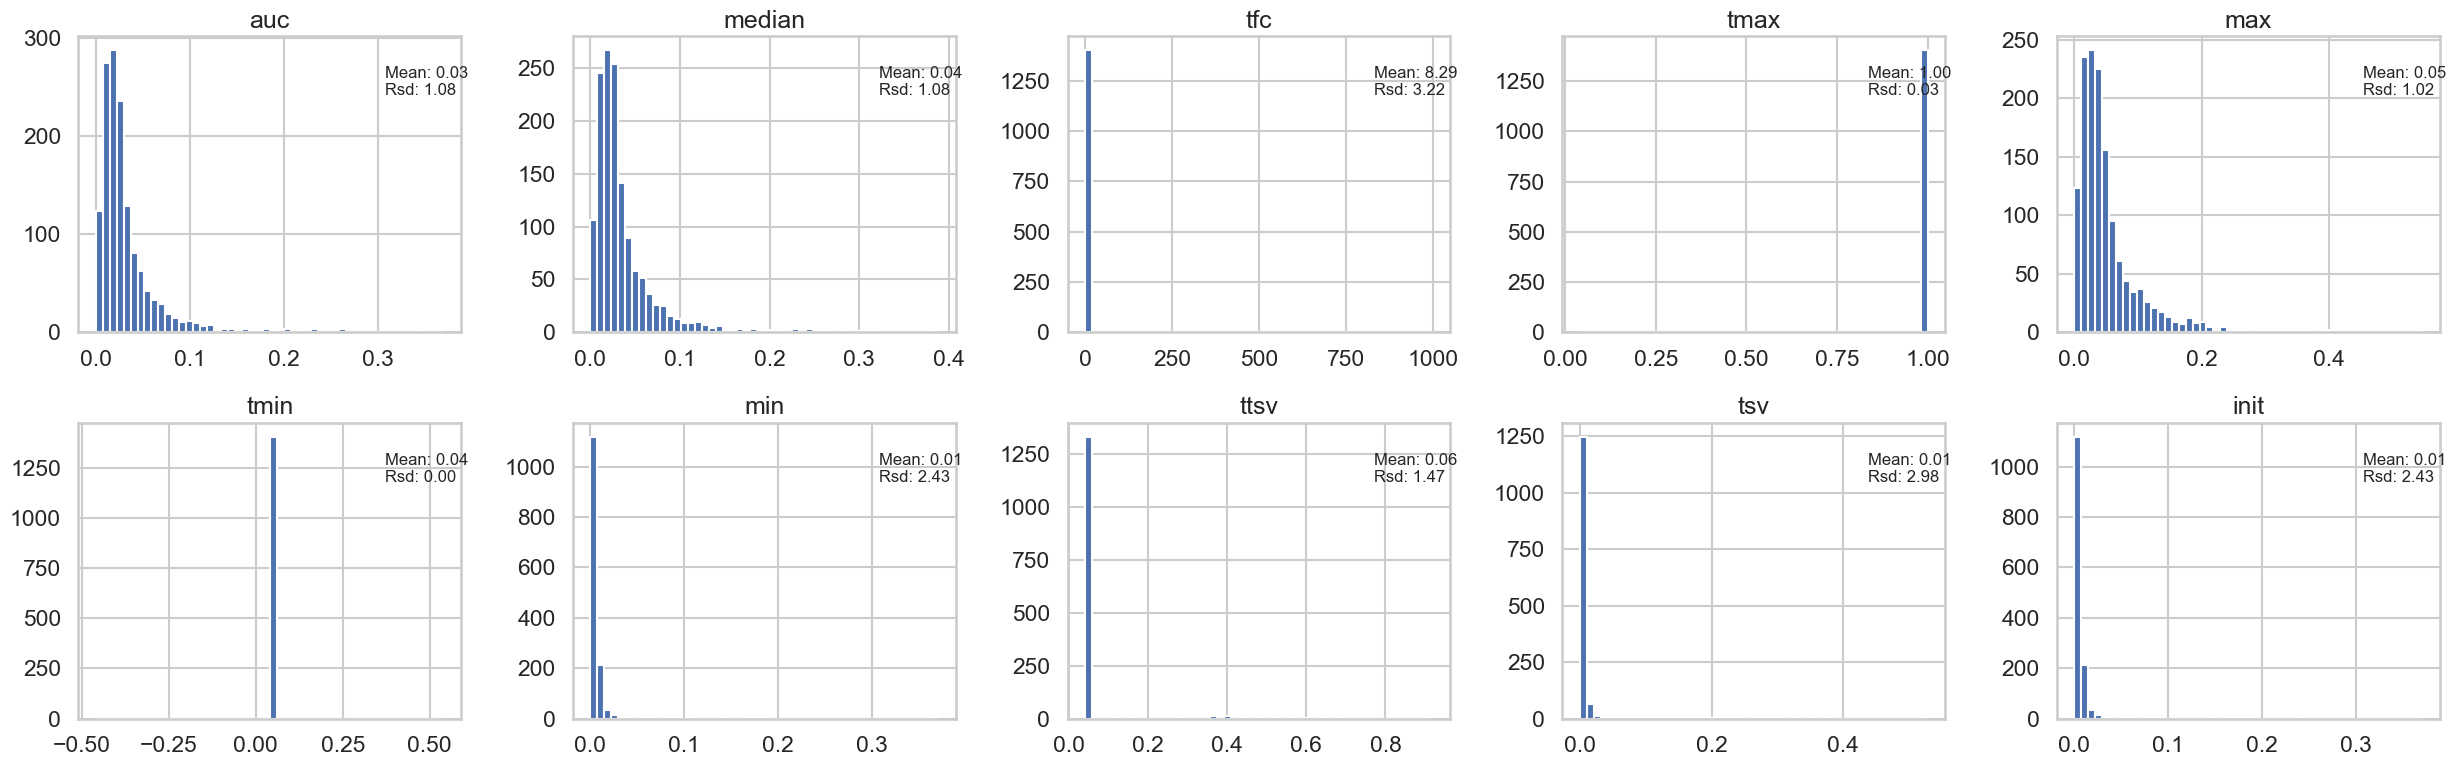

In [16]:
# for each column in joint_dynamic_features, plot histogram of values
import math 

plot_cols = 5
plot_rows = 2
plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))

for i, col in enumerate(mean_df.index):
    plt.subplot(plot_rows, plot_cols, i+1)
    plt.hist(joint_dynamic_features[col], bins=50)
    plt.text(0.8, 0.8, f'Mean: {mean_df[col]:.2f}\nRsd: {rsd_df[col]:.2f}', fontsize=12, transform=plt.gca().transAxes)
    plt.title(col)
    
plt.tight_layout()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_dyn_feat_histograms_{fixed_random_seed}.png')
if not display_figure: plt.close() 
else: plt.show()

## All Species Variance Analysis

by measuring the rsd of all dynamic features for each protein specie

In [17]:
species_list = simulation_data.columns[2:].tolist()

In [18]:
indexed_dyn_feats = dynamic_features.set_index('Row')
columns = indexed_dyn_feats.columns
target_dynamic_features = indexed_dyn_feats.filter(like=target_protein, axis=1)

dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']
filtered_cols = [col for col in columns if col.startswith(target_protein+"_")]
filtered_data = indexed_dyn_feats[filtered_cols]
    
filtered_data.columns = dyn_feat_cols
filtered_data


,auc,median,tfc,tmax,max,tmin,min,ttsv,tsv,init
Row,,,,,,,,,,
ACH-001113,0.019879,0.022585,5.339313,1.0,0.029060,0.04,0.004584,0.04,0.004584,0.004584
ACH-001289,0.047131,0.051773,9.378872,1.0,0.083667,0.04,0.008061,0.04,0.008061,0.008061
ACH-001339,0.107427,0.124875,11.832264,1.0,0.183883,0.04,0.014330,0.40,0.099500,0.014330
ACH-001538,0.018977,0.020471,6.192774,1.0,0.033563,0.04,0.004666,0.04,0.004666,0.004666
ACH-000242,0.019410,0.021032,4.682872,1.0,0.032885,0.04,0.005787,0.04,0.005787,0.005787
...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.051886,0.059549,14.115679,1.0,0.092129,0.04,0.006095,0.04,0.006095,0.006095
ACH-002669,0.019672,0.022874,8.579873,1.0,0.030418,0.04,0.003175,0.04,0.003175,0.003175
ACH-001858,0.029551,0.033124,10.070813,1.0,0.051003,0.04,0.004607,0.04,0.004607,0.004607


In [21]:
import math
from tqdm import tqdm
display_figure_long = False

all_rsd_df_data = []

for target_protein in tqdm(species_list): 

    # Data preparation
    indexed_dyn_feats = dynamic_features.set_index('Row')
    columns = indexed_dyn_feats.columns
    target_dynamic_features = indexed_dyn_feats.filter(like=target_protein, axis=1)

    dyn_feat_cols = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']
    filtered_cols = [col for col in columns if col.startswith(target_protein+"_")]
    filtered_data = indexed_dyn_feats[filtered_cols]
        
    filtered_data.columns = dyn_feat_cols
    joint_dynamic_features = filtered_data

    # UMAP projection
    standard_embedding = umap.UMAP(**umap_params).fit_transform(joint_dynamic_features)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)
    plt.title(f'UMAP Projection of Dynamic Features for {target_protein}')
    if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{target_protein}_dyn_feat_umap_{fixed_random_seed}.png')
    if not display_figure_long: plt.close() 
    else: plt.show()
    
    # HBDScan clustering
    hbd_labels = hdbscan.HDBSCAN(**hbd_params).fit_predict(joint_dynamic_features)
    n_clusters = set(hbd_labels)
    plot_colors_cluster = sns.color_palette("husl", len(list(n_clusters)))

    for k, cluster in enumerate(list(n_clusters)):
        plot_data_x = []
        plot_data_y = []
        for i, label in enumerate(hbd_labels):
            if label == cluster:
                x = standard_embedding[i][0]
                y = standard_embedding[i][1]
                plot_data_x.append(x)
                plot_data_y.append(y)

        plt.scatter(plot_data_x, plot_data_y, color=plot_colors_cluster[k], s=0.2, label=cluster, alpha=0.9) 
        
    if projection_show_legend: plt.legend()
    plt.title('HBDScan Cluster of Dynamic Features')
    if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{target_protein}_dyn_feat_hbdscan_cluster_{fixed_random_seed}.png')
    if not display_figure_long: plt.close() 
    else: plt.show()
    
    # HBDScan Clustered Simulation Visualisation

    all_celllines = simulation_data['Cellline'].unique()
    all_proteins = simulation_data.columns[2:]

    protein_simulation_dynamics = []
    protein_simulation_dynamics_dict = {}
    for n in n_clusters:
        protein_simulation_dynamics_dict[n] = []

    protein_df_data = []
    count = 0
    for cellline in all_celllines:
        cellline_protein_data = simulation_data[(simulation_data['Cellline'] == cellline)]
        protein_data = cellline_protein_data[target_protein]
        cluster_group = hbd_labels[count]
        protein_simulation_dynamics_dict[cluster_group].append(protein_data.tolist())
        count += 1

    cluster_key = []
    for key, data in protein_simulation_dynamics_dict.items():
        time_column_df = pd.DataFrame(data, columns=cellline_protein_data['Time'])
        protein_simulation_dynamics.append(time_column_df)
        cluster_key.append(key)
    
    plot_cols = ncluster_plot_cols
    plot_rows = math.ceil(len(list(n_clusters))/plot_cols)

    plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))
    for i, df in enumerate(protein_simulation_dynamics):
        plt.subplot(plot_rows, plot_cols, i+1)
        if normalise_simulation_dynamics: 
            # perform min-max normalisation
            new_df = (df - df.min()) / (df.max() - df.min())
        for j in range(df.shape[0]):
            if normalise_simulation_dynamics:
                plt.plot(cellline_protein_data['Time'], new_df.iloc[j], alpha=0.3, color=plot_colors_cluster[i])
            else:
                plt.plot(cellline_protein_data['Time'], df.iloc[j], alpha=0.3, color=plot_colors_cluster[i])
        plt.title(cluster_key[i])
        plt.xlabel('Time (min)')
        plt.ylabel('Protein expression (n.u.)')
    plt.tight_layout()
    if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{target_protein}_dyn_feat_hbdscan_cluster_plots_{fixed_random_seed}.png')
    if not display_figure_long: plt.close() 
    else: plt.show()

    # RSD (Coefficient of Variance) calculation and variance charts
    mean_df = joint_dynamic_features.mean()
    std_df = joint_dynamic_features.std()
    rsd_df = std_df / mean_df
    all_rsd_df_data.append(rsd_df)
    
    plot_cols = 5
    plot_rows = 2
    plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))

    for i, col in enumerate(mean_df.index):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.hist(joint_dynamic_features[col], bins=50)
        plt.text(0.8, 0.8, f'Mean: {mean_df[col]:.2f}\nRsd: {rsd_df[col]:.2f}', fontsize=12, transform=plt.gca().transAxes)
        plt.title(col)
    
    plt.suptitle(f'Feature Histograms for {target_protein}')    
    plt.tight_layout()
    if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{target_protein}_dyn_feat_histograms_{fixed_random_seed}.png')
    if not display_figure_long: plt.close() 
    else: plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  4%|▍         | 1/26 [00:12<05:00, 12.04s/it]c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  8%|▊         | 2/26 [00:23<04:41, 11.71s/it]c:\Github\ode-biomarker-project\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
 12%|█▏        | 3/26 [00:34<04:26, 11.58s/it]c:\Github\ode-bi

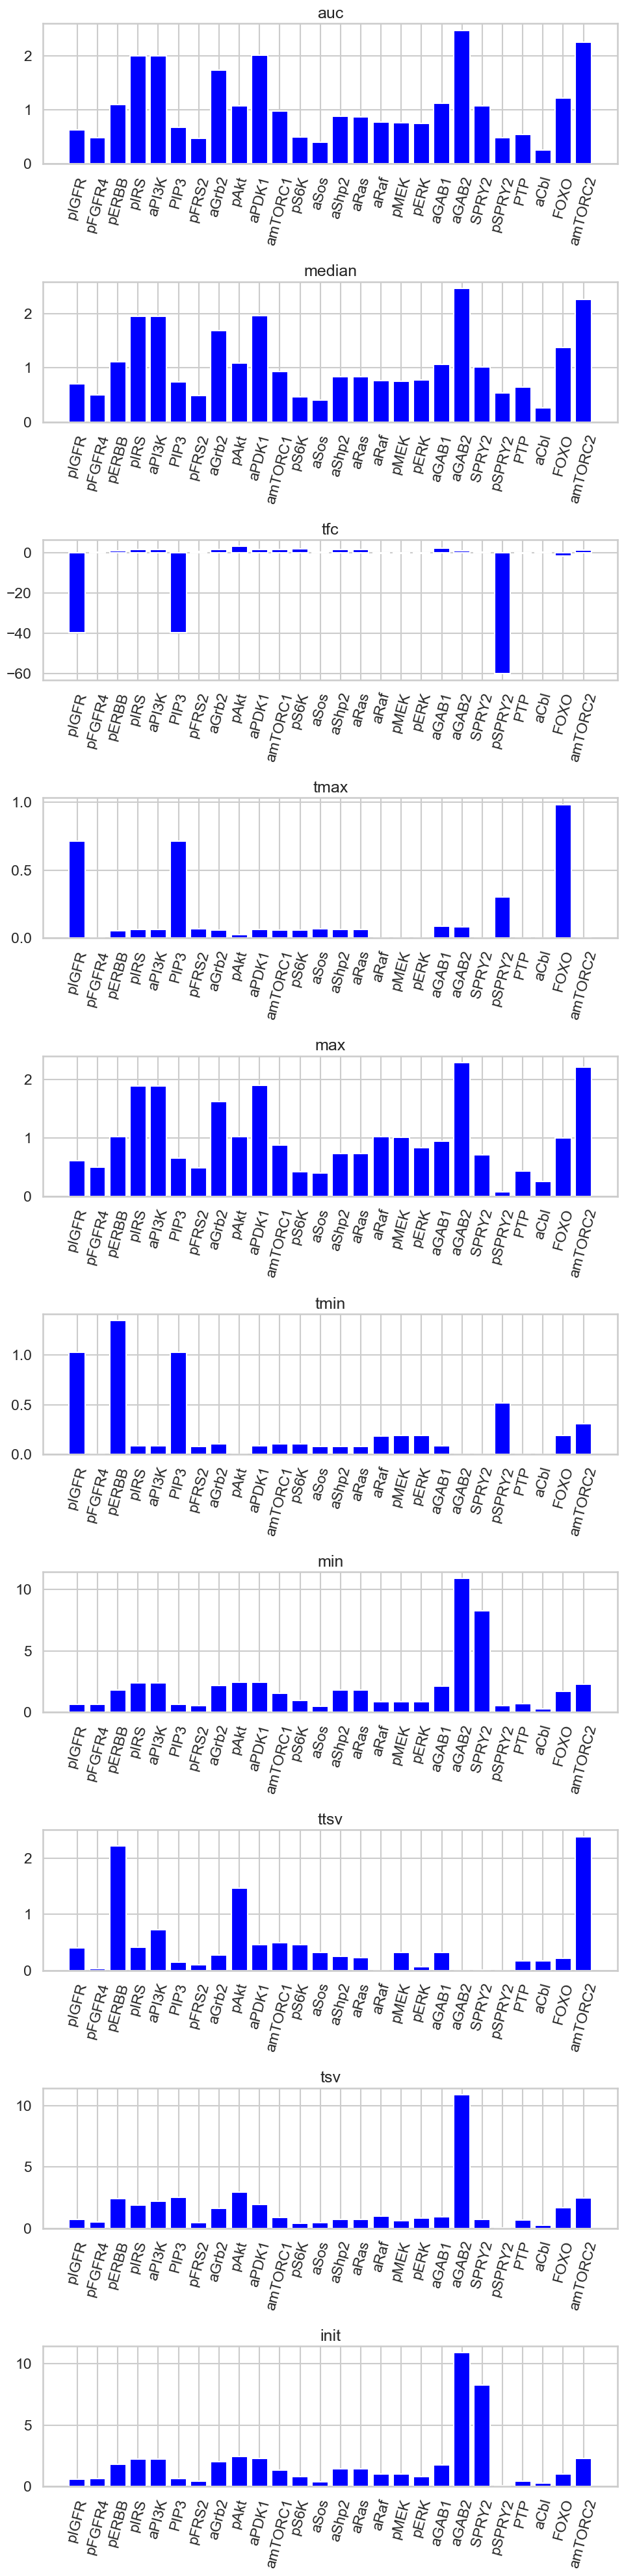

In [22]:
# re-orient all rsd data

all_rsd_df = pd.concat(all_rsd_df_data, axis=1)
all_rsd_df.columns = species_list

# plot each row of the rsd data

plot_cols = 1
plot_rows = 10
plt.subplots(plot_rows, plot_cols, figsize=(10*plot_cols, 4*plot_rows))

for i, row in enumerate(all_rsd_df.index):
    plt.subplot(plot_rows, plot_cols, i+1)
    plt.bar(all_rsd_df.columns, all_rsd_df.loc[row].values, color='blue')
    xticks = plt.xticks(rotation=75)
    plt.title(row)
    
# plt.suptitle('RSD of Dynamic Features for Each Protein')
plt.tight_layout()